In [112]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import sem
from scipy.stats import linregress

#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("crime.csv")


In [113]:
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)



In [114]:
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

In [7]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])


In [8]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)


In [9]:
#create dataframe for speends over 40mph 
wind_df = weather.loc[weather.Wind > 40]
wind_df
weather['Date & Time'] = weather['Date'] + ' ' + weather['Hour']
weather['Date & Time'] = weather['Date & Time'].astype('datetime64[ns]')
weather = weather.drop(columns =['Date', 'Hour'])


In [10]:
# Narrowing crime data down to correct Denver lat/lon specs

crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]


In [11]:
#create dataframe for temps under 10f 
cold_df = weather.loc[weather['Temp Max'] < 10]


In [12]:
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])


In [13]:
crime.head()
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)

In [14]:
# df = pd.DataFrame([{'old_column':pd.Timestamp('2015-07-18 13:53:33.280')}])
crime['Date'] = crime['Date'].dt.round('60min')
crime

,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date
0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00
1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00
2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00
3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00
4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00
5,5499,traf-other,all-other-crimes,2100 BLOCK E 17TH AVE,-104.961928,39.743149,622,city-park-west,1,0,2018-01-31 01:00:00
6,2304,theft-parts-from-vehicle,theft-from-motor-vehicle,995 N FEDERAL BLVD,-105.025543,39.732790,122,villa-park,1,0,2017-06-01 12:00:00
7,5707,criminal-trespassing,all-other-crimes,E SPEER BLVD / N GRANT ST,-104.983794,39.723423,311,speer,1,0,2018-01-30 08:00:00
8,5401,traffic-accident-hit-and-run,traffic-accident,W 13TH AVE / N CHEROKEE ST,-104.991650,39.736863,611,civic-center,0,1,2018-01-30 09:00:00
9,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2828 N ZUNI ST,-105.015451,39.757627,113,highland,1,0,2018-01-31 01:00:00


In [15]:
weather.head()
weather = weather.rename(columns = {'Date & Time':'Date'})

In [16]:
crime_weather = pd.merge(crime, weather, on='Date', how='left')

In [17]:
crime_weather.head()

,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds
0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00,Denver,89.69,93.99,18.34,20.0
1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0
2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0
3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0
4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0


In [18]:
crime_weather.to_csv('crime_weather.csv')

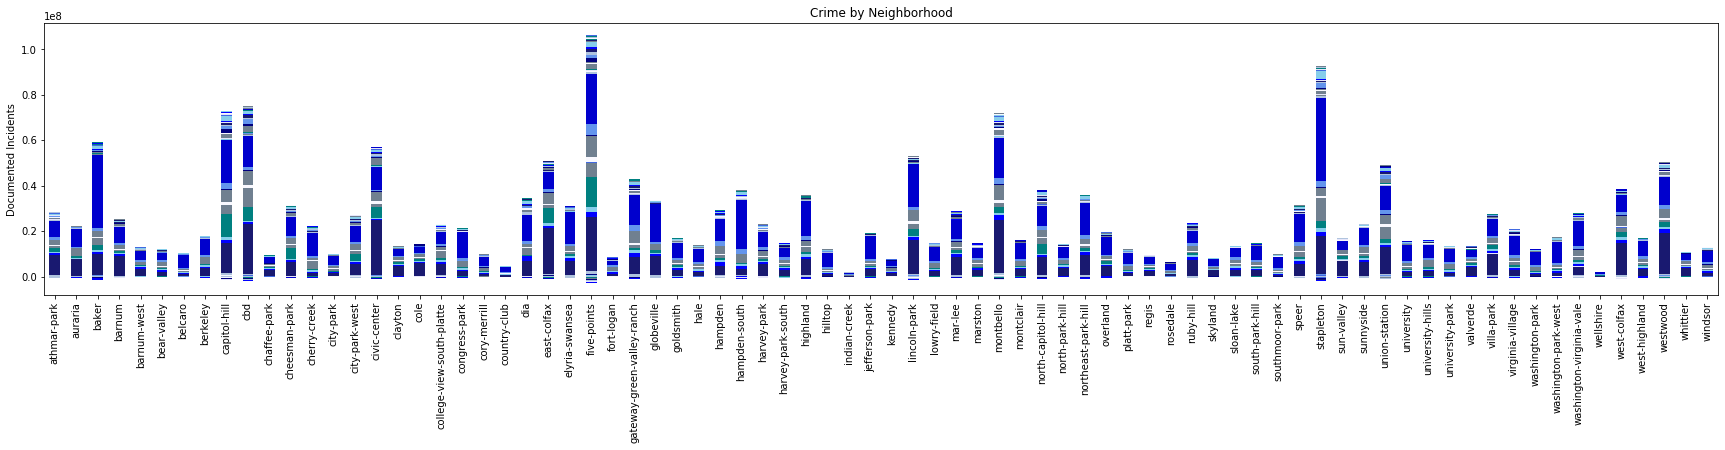

In [116]:
# Playing with crime by neighborhood -EN

neighborhood_pivot = crime_weather.pivot_table(crime_weather, index='Neighborhood', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')

colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey','royalblue','ghostwhite',
          'slategrey','navy','cornflowerblue']

neighborhood_pivot.plot.bar(stacked=True, color=colors, figsize=(30,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Crime by Neighborhood")
plt.show()


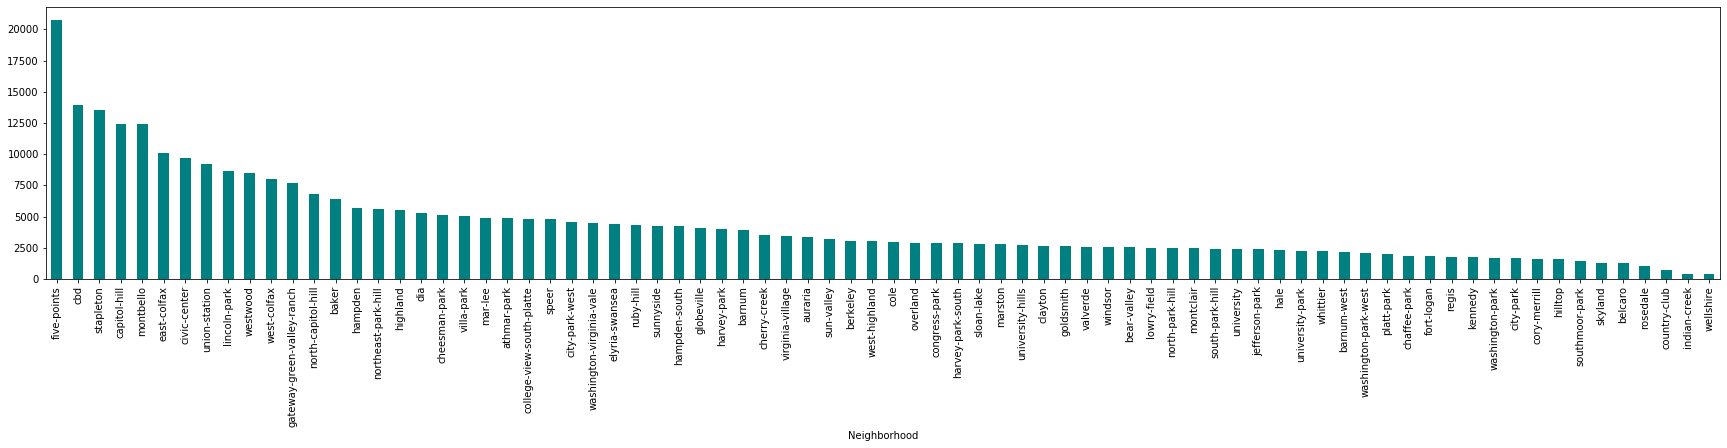

In [122]:
# Playing with crime by neighborhood -EN

groupn_count_df = crime_weather.groupby("Neighborhood").sum()
neighborhood_crime = groupn_count_df["IS_CRIME"].sort_values(ascending=False)

neighborhood_crime.plot.bar(colors="teal", figsize=(30,5))

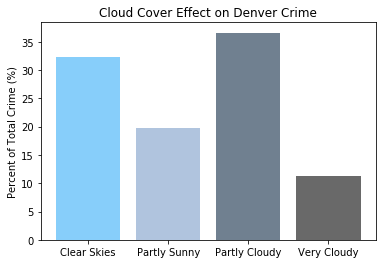

,Code,Lon,Lat,Precint,IS_CRIME,IS_TRAFFIC,Temp,Temp Max,Wind,Clouds,Percent of Total
Cloud Bins,,,,,,,,,,,
Clear Skies,571167373,-1.558907e+07,5.901184e+06,54729406,107443,41186,7953675.92,8.303662e+06,1289466.29,2311588.0,32.346955
Partly Sunny,341377566,-9.365818e+06,3.545347e+06,32852499,65428,23833,5072218.99,5.270168e+06,782143.10,3568345.0,19.697855
Partly Cloudy,603529532,-1.672477e+07,6.331001e+06,58844947,121549,37878,9093030.44,9.441957e+06,1434917.07,11939392.0,36.593729
Very Cloudy,209094786,-5.617634e+06,2.126521e+06,19625815,37738,15817,2043703.86,2.128780e+06,460651.18,4835582.0,11.361461


In [89]:
# What is the effect of cloud cover on Denver Crime? -EN

# Binned by cloud cover
bins = [0, 25, 50, 75, 100]
groups = ['Clear Skies', 'Partly Sunny', 'Partly Cloudy', 'Very Cloudy']
crime_weather["Cloud Bins"] = pd.cut(crime_weather["Clouds"], bins, labels=groups)

# Groupby to find sum of crime in each cloudcover bin
cloud_sum = crime_weather.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloud_sum["Percent of Total"] = (cloud_sum["IS_CRIME"] / cloud_sum["IS_CRIME"].sum()) * 100

# Cloud cover bar plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloud_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Crime (%)")
plt.title("Cloud Cover Effect on Denver Crime")

plt.show()

cloud_sum.head()

Clouds                                       \
OFFENSE_CATEGORY_ID aggravated-assault all-other-crimes    arson auto-theft   
Cloud Bins                                                                    
Clear Skies                    56642.0         411253.0   2360.0   125336.0   
Partly Sunny                   91221.0         624108.0   4291.0   201150.0   
Partly Cloudy                 318631.0        2287754.0  17097.0   697603.0   
Very Cloudy                    95267.0         844567.0   4520.0   273899.0   

                                                               \
OFFENSE_CATEGORY_ID  burglary drug-alcohol    larceny  murder   
Cloud Bins                                                      
Clear Skies          112292.0     152132.0   238375.0  1555.0   
Partly Sunny         171579.0     241242.0   372851.0  2004.0   
Partly Cloudy        592018.0     782156.0  1181862.0  9058.0   
Very Cloudy          225255.0     276265.0   475009.0  2808.0   

                                                                  ...  \
OFFENSE_CATEGORY_ID other-crimes-against-persons public-disorder  ...   
Cloud Bins                                                        ...   
Clear Skies                             116964.0        231042.0  ...   
Partly Sunny                            173464.0        356277.0  ...   
Partly Cloudy                           616311.0       1280817.0  ...   
Very Cloudy                             224894.0        468747.0  ...   

                         Wind                                   \
OFFENSE_CATEGORY_ID  burglary drug-alcohol    larceny   murder   
Cloud Bins                                                       
Clear Skies          64174.03     80510.34  131619.83   843.81   
Partly Sunny         38109.67     51808.69   80219.97   541.51   
Partly Cloudy        71147.93     91664.00  138388.50  1069.69   
Very Cloudy          21447.60     25588.02   43870.01   309.27   

                                                                            \
OFFENSE_CATEGORY_ID other-crimes-against-persons public-disorder   robbery   
Cloud Bins                                                                   
Clear Skies                             64521.04       128617.11  15815.98   
Partly Sunny                            38644.34        79286.56  10449.29   
Partly Cloudy                           76015.60       157762.08  21771.13   
Very Cloudy                             22486.32        45456.43   5630.03   

                                                               \
OFFENSE_CATEGORY_ID theft-from-motor-vehicle traffic-accident   
Cloud Bins                                                      
Clear Skies                        102537.35        353790.86   
Partly Sunny                        63840.50        203288.67   
Partly Cloudy                      123902.47        328747.54   
Very Cloudy                         37033.68        131653.32   

                                        
OFFENSE_CATEGORY_ID white-collar-crime  
Cloud Bins                              
Clear Skies                   19099.50  
Partly Sunny                  10941.27  
Partly Cloudy                 17262.64  
Very Cloudy                    7404.94  

[4 rows x 140 columns]

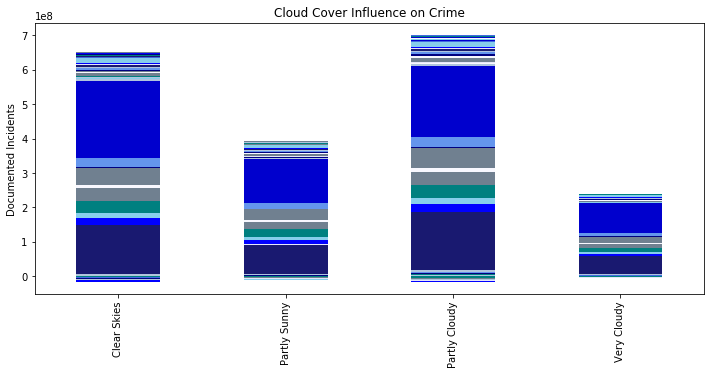

In [106]:
# Playing with crime by cloud cover -EN

# Cloud pivot
cloud_pivot = crime_weather.pivot_table(crime_weather, index='Cloud Bins', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')

# Cloud cover stacked
colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey','royalblue','ghostwhite',
          'slategrey','navy','cornflowerblue']
cloud_pivot.plot.bar(stacked=True, color=colors, figsize=(12,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Cloud Cover Influence on Crime")
plt.show()